# Electrode State of Health

This notebook demonstrates some utilities to work with electrode State of Health (also sometimes called electrode stoichiometry), using the algorithm from Mohtat et al [1]

[1] Mohtat, P., Lee, S., Siegel, J. B., & Stefanopoulou, A. G. (2019). Towards better estimability of electrode-specific state of health: Decoding the cell expansion. Journal of Power Sources, 427, 101-111.

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas
import pickle
import os.path

In [2]:
XLS_FILE='GMJuly2022_CELL067_RPT_1_P25C_5P0PSI_20220912_R0_CH012.csv_20220912211108_36_2_4_2818579440.xlsx'
VDF_FILE='GMJuly2022_CELL067_RPT_1_P25C_5P0PSI_20220912_R0_CH012.csv'



file_exists = os.path.exists(XLS_FILE[0:-5]+".p")
if file_exists:
    neware_data_df=pickle.load( open( XLS_FILE[0:-5]+".p", "rb" ) )
else:
    neware_data_df = pandas.read_excel(XLS_FILE, sheet_name='record')
    neware_data_df['Time'] =  pandas.to_datetime(neware_data_df['Time'],format='%H:%M:%S.%f')
    pickle.dump( neware_data_df, open( XLS_FILE[0:-5]+".p", "wb" ) )


Is list strictly increasing ? : True


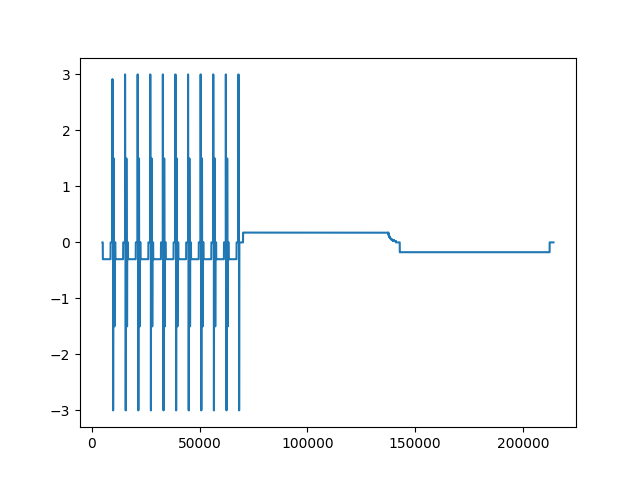

In [3]:
import datetime
times=neware_data_df['Total Time'].values
#A=times[222]
#B=[int(x) for x in A.split(':')]
# get hours, minutes and seconds
tm1 = [x.split(':') for x in times]
# convert to timedelta
#tm2 = [datetime.timedelta(hours=int(x[0]), minutes=int(x[1]), seconds=int(x[2])) for x in tm1]
tm2 = [60*(60*int(x[0])+int(x[1]))+float(x[2]) for x in tm1]
neware_data_df['Total Time']=tm2

neware_data_df.sort_values("Total Time", inplace=True)
neware_data_df.drop_duplicates(subset=["Total Time"],inplace=True)
starttime_index=neware_data_df[neware_data_df["Current(A)"].lt(0)].index[0]-100

data_time=neware_data_df.loc[starttime_index:,"Total Time"].values
data_voltage=neware_data_df.loc[starttime_index:,"Voltage(V)"].values
data_current=neware_data_df.loc[starttime_index:,"Current(A)"].values
#data_time.head(10)
res = all(i < j for i, j in zip(data_time, data_time[1:]))
 
# printing result
print ("Is list strictly increasing ? : " + str(res))

neware_data_df.plot(x='Total Time',y='Voltage(V)')
#expansion_data.plot(x='Timestamp',y='LDC SENSOR')

%matplotlib widget
plt.plot(data_time,data_current)

## Create and solve model

interactive(children=(FloatSlider(value=0.0, description='t', max=18.917305412307368, step=0.18917305412307367…

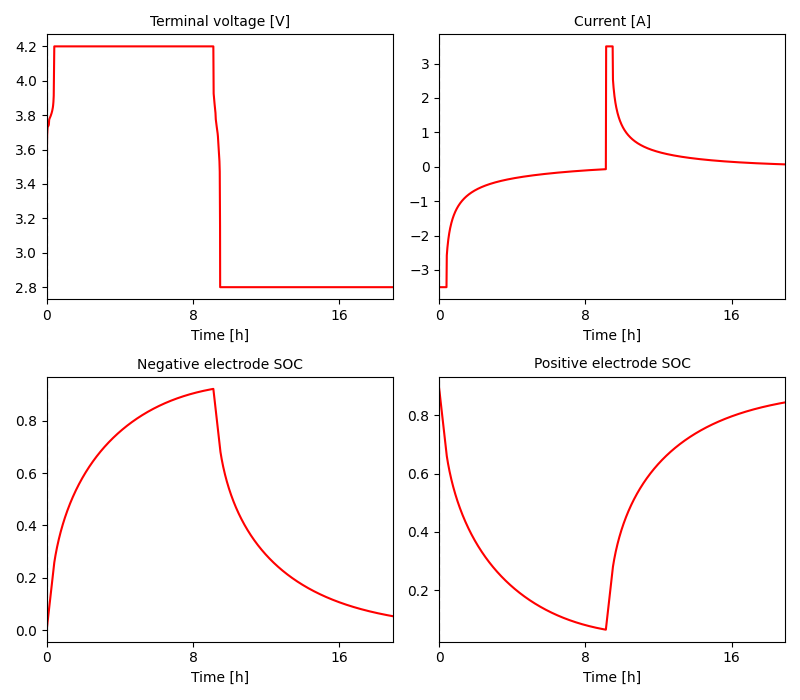

In [4]:
spm = pybamm.lithium_ion.SPM()
experiment = pybamm.Experiment([
    "Charge at 1C until 4.2V", 
    "Hold at 4.2V until C/50",
    "Discharge at 1C until 2.8V",
    "Hold at 2.8V until C/50",
])
parameter_values = pybamm.ParameterValues("Siegel2022")
#("Mohtat2020")

sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()
spm_sol.plot([
    "Terminal voltage [V]", 
    "Current [A]", 
    "Negative electrode SOC",
    "Positive electrode SOC",
])

## Solve for electrode SOH variables

Given a total amount of lithium, $n_{Li}$, electrode capacities, $C_n$ and $C_p$, and voltage limits, $V_{min}$ and $V_{max}$, we can solve for the min and max electrode SOCs, $x_0$, $x_{100}$, $y_0$, and $y_{100}$,  and the cell capacity, $C$, using the algorithm from Mohtat et al [1].
First, we find $x_{100}$ and $y_{100}$ using
$$
\begin{align}
n_{Li} &= \frac{3600}{F}(y_{100}C_p + x_{100}C_n),
\\
V_{max} &= U_p(y_{100}) - U_n(x_{100}).
\end{align}
$$
Then, we find $C$ using
$$
\begin{align}
V_{min} &= U_p(y_{0}) - U_n(x_{0})
\\
&= U_p\left(y_{100} + \frac{C}{C_p}\right) - U_n\left(x_{100} - \frac{C}{C_n}\right)
\end{align}
$$
Finally, $x_0$ and $y_0$ are simply defined as
$$
\begin{align}
x_0 &= x_{100} - \frac{C}{C_n},
\\
y_0 &= y_{100} + \frac{C}{C_p}.
\end{align}
$$
We implement this in pybamm as an algebraic model.

In [5]:
param = pybamm.LithiumIonParameters()

Vmin = 2.8
Vmax = 4.2
Cn = parameter_values.evaluate(param.n.cap_init)
Cp = parameter_values.evaluate(param.p.cap_init)
n_Li = parameter_values.evaluate(param.n_Li_particles_init)

Un = param.n.prim.U_dimensional
Up = param.p.prim.U_dimensional
T_ref = param.T_ref

In [6]:
# First we solve for x_100 and y_100

model = pybamm.BaseModel()

x_100 = pybamm.Variable("x_100")
y_100 = (n_Li * param.F / 3600 - x_100 * Cn) / Cp

y_100_min = 1e-10

x_100_upper_limit = ((n_Li * param.F) / 3600 - y_100_min*Cp)/Cn

if not isinstance(x_100_upper_limit, float):
    x_100_upper_limit = x_100_upper_limit.value
    
x_100_upper_limit = min(x_100_upper_limit, 1-1e-10)


Vmax_init = parameter_values.evaluate(Up(y_100_min, T_ref)) - parameter_values.evaluate(Un(x_100_upper_limit, T_ref))
Vmin_init = parameter_values.evaluate(Up(y_100_min + 1, T_ref)) - parameter_values.evaluate(Un(x_100_upper_limit - Cp/Cn, T_ref))


if isinstance(parameter_values["Positive electrode OCP [V]"], tuple):
    # if data is provided for the Positive (or Negative) electrode OCP [V] 
    # the intial conditions must be within the bounds of this data to prevent extrapolation errors
    y_100_min = np.min(parameter_values["Positive electrode OCP [V]"][1][1])
    x_100_upper_limit = (n_Li * pybamm.constants.F.value / 3600 - y_100_min * Cp) / Cn

    V_lower_bound = min(parameter_values["Positive electrode OCP [V]"][1][1]) - parameter_values["Negative electrode OCP [V]"](x_100_upper_limit).evaluate()
    V_upper_bound = max(parameter_values["Positive electrode OCP [V]"][1][1]) - parameter_values["Negative electrode OCP [V]"](x_100_upper_limit).evaluate()

    if Vmin_init[0][0] < V_lower_bound:
        raise(ValueError("Initial voltage is outside bounds of OCP data in parameter set. Revise initial values."))

    if Vmax_init[0][0] > V_upper_bound:
        raise(ValueError("Initial voltage is outside bounds of OCP data in parameter set. Revise initial values."))


model.algebraic = {
    x_100: Up(y_100, T_ref) - Un(x_100, T_ref) - Vmax + 1e5*(y_100<0) + 1e5*(x_100>1),
}
    
model.initial_conditions = {
    x_100: x_100_upper_limit
}

model.variables = {
    "x_100": x_100,
    "y_100": y_100
}


sim = pybamm.Simulation(model, parameter_values=parameter_values)

sol = sim.solve([0])

x_100 = sol["x_100"].data[0]
y_100 = sol["y_100"].data[0]

for var in ["x_100", "y_100"]:
    print(var, ":", sol[var].data[0])

# Based on the calculated values for x_100 and y_100 we solve for C
model = pybamm.BaseModel()

C = pybamm.Variable("C")
x_0 = x_100 - C/Cn
y_0 = y_100 + C/Cp

model.algebraic = {
    C: Up(y_0, T_ref) - Un(x_0, T_ref) - Vmin
}

model.initial_conditions = {C: pybamm.minimum(Cn * x_100 - 0.1, param.Q)}

model.variables = {
    "C": C,
    "x_0": x_0,
    "y_0": y_0,
}

sim = pybamm.Simulation(model, parameter_values=parameter_values)
sol = sim.solve([0])


for var in ["C", "x_0", "y_0"]:
    print(var, ":", sol[var].data[0])

x_100 : 0.9499882368906248
y_100 : 0.03883389925677596
C : 5.3030163860868145
x_0 : 0.001511470257482883
y_0 : 0.8908703211868462


This is implemented in PyBaMM as the `ElectrodeSOHSolver` class

In [7]:
esoh_solver = pybamm.lithium_ion.ElectrodeSOHSolver(parameter_values, param)

inputs={ "V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li}

esoh_sol = esoh_solver.solve(inputs)

for var in ["x_100", "y_100", "C", "x_0", "y_0"]:
    print(var, ":", esoh_sol[var].data[0])

x_100 : 0.9499882368881947
y_100 : 0.0388338992589589
C : 5.303016383332267
x_0 : 0.0015114707477203969
y_0 : 0.8908703207464554


## Check against simulations

Plotting the SPM simulations against the eSOH calculations validates the min/max stoichiometry calculations

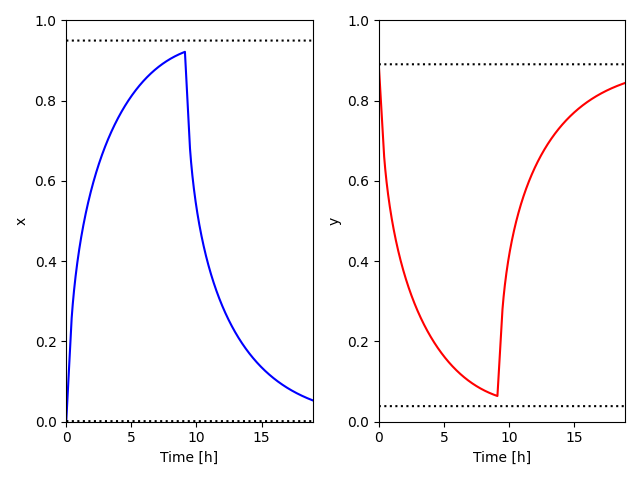

In [8]:
t = spm_sol["Time [h]"].data
x_spm = spm_sol["Negative electrode SOC"].data
y_spm = spm_sol["Positive electrode SOC"].data

x_0 = esoh_sol["x_0"].data * np.ones_like(t)
y_0 = esoh_sol["y_0"].data * np.ones_like(t)
x_100 = esoh_sol["x_100"].data * np.ones_like(t)
y_100 = esoh_sol["y_100"].data * np.ones_like(t)

fig, axes = plt.subplots(1,2)

axes[0].plot(t, x_spm, "b")
axes[0].plot(t, x_0, "k:")
axes[0].plot(t, x_100, "k:")
axes[0].set_ylabel("x")
    
axes[1].plot(t, y_spm, "r")
axes[1].plot(t, y_0, "k:")
axes[1].plot(t, y_100, "k:")
axes[1].set_ylabel("y")
    
for k in range(2):
    axes[k].set_xlim([t[0],t[-1]])
    axes[k].set_ylim([0,1])    
    axes[k].set_xlabel("Time [h]")
    
fig.tight_layout()


## References

The relevant papers for this notebook are:

In [ ]:
pybamm.print_citations()